# Modelling

## Import Libraries

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import umap.umap_ as umap
from sklearn.manifold import TSNE

import joblib


## Load datasets

In [18]:
df = pd.read_csv('../data/cleaned_Kenya_Fraud_data.csv')

In [19]:
X_df = pd.read_csv('../data/X_preprocessed.csv')

### Load preprocessor

In [20]:
preprocessor = joblib.load('../models/preprocessor.joblib')

## Check datasets

In [21]:
print("df shape:", getattr(df, 'shape', None))
print("X_df shape:", getattr(X_df, 'shape', None))


df shape: (10000, 17)
X_df shape: (10000, 35)


#### Ensure number of rows match

In [22]:
if X_df.shape[0] != df.shape[0]:
    print(">>> WARNING: row-count mismatch between df and X_df.")
    print("    df rows:", df.shape[0], ", X_df rows:", X_df.shape[0])
else:
    print("Row counts match: OK")

Row counts match: OK


## check for nulls and infinite values


In [23]:
print("\nNulls in df (top 10 cols):")
print(df.isnull().sum().sort_values(ascending=False).head(10))




Nulls in df (top 10 cols):
transaction_id             0
is_sim_recently_swapped    0
time_of_day                0
dayofweek                  0
hour                       0
date                       0
datetime                   0
has_multiple_accounts      0
is_foreign_number          0
user_id                    0
dtype: int64


In [24]:
print("\nNulls in X_df (total):", X_df.isnull().sum().sum())
print("Any infinite or NaN in X_df (rows):", np.any(~np.isfinite(X_df.values)))



Nulls in X_df (total): 0
Any infinite or NaN in X_df (rows): False


## feature info

In [25]:

X_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   is_foreign_number                    10000 non-null  float64
 1   is_sim_recently_swapped              10000 non-null  float64
 2   has_multiple_accounts                10000 non-null  float64
 3   transaction_type_   Withdraw   Cash  10000 non-null  float64
 4   transaction_type_  Buy    Airtime    10000 non-null  float64
 5   transaction_type_  Send   Money      10000 non-null  float64
 6   transaction_type_ Buy   Airtime      10000 non-null  float64
 7   transaction_type_Buy Airtime         10000 non-null  float64
 8   transaction_type_Deposit Cash        10000 non-null  float64
 9   transaction_type_Lipa   na M-Pesa    10000 non-null  float64
 10  transaction_type_Lipa na    M-Pesa   10000 non-null  float64
 11  transaction_type_Lipa na M-Pe

## show a few rows from original df and X_df so we can inspect index alignment

In [26]:
print("\nOriginal df sample (first 5 rows):")
df.head()[list(df.columns[:10])]  # show first 10 cols of df for space




Original df sample (first 5 rows):


,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,is_foreign_number,is_sim_recently_swapped
0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,0,0
1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,0,0
2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,0,0
3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,0,0
4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,0,0


In [27]:
print("\nX_df sample (first 5 rows):")
X_df.head()


X_df sample (first 5 rows):


,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,transaction_type_ Withdraw Cash,transaction_type_ Buy Airtime,transaction_type_ Send Money,transaction_type_ Buy Airtime,transaction_type_Buy Airtime,transaction_type_Deposit Cash,transaction_type_Lipa na M-Pesa,...,location_Nyeri,location_Thika,device_type_Android,device_type_Feature Phone,device_type_iOS,network_provider_Airtel,network_provider_Safaricom,network_provider_Telkom Kenya,user_type_agent,user_type_individual
0,-0.184443,-0.23373,-0.326063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.184443,-0.23373,-0.326063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.184443,-0.23373,3.066892,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.184443,-0.23373,3.066892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.184443,-0.23373,-0.326063,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


## Check Unique Columns

In [28]:
print(X_df.columns)

Index(['is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts',
       'transaction_type_   Withdraw   Cash',
       'transaction_type_  Buy    Airtime', 'transaction_type_  Send   Money',
       'transaction_type_ Buy   Airtime  ', 'transaction_type_Buy Airtime',
       'transaction_type_Deposit Cash', 'transaction_type_Lipa   na M-Pesa',
       'transaction_type_Lipa na    M-Pesa', 'transaction_type_Lipa na M-Pesa',
       'transaction_type_Pay    Bill', 'transaction_type_Pay Bill',
       'transaction_type_Send   Money', 'transaction_type_Send Money',
       'transaction_type_Withdraw Cash', 'location_Eldoret',
       'location_Garissa', 'location_Kisumu', 'location_Machakos',
       'location_Meru', 'location_Mombasa', 'location_Nairobi',
       'location_Nakuru', 'location_Nyeri', 'location_Thika',
       'device_type_Android', 'device_type_Feature Phone', 'device_type_iOS',
       'network_provider_Airtel', 'network_provider_Safaricom',
       'network_provider_Te

In [29]:
print(df.columns)

Index(['transaction_id', 'user_id', 'transaction_type', 'amount', 'location',
       'device_type', 'network_provider', 'user_type', 'is_foreign_number',
       'is_sim_recently_swapped', 'has_multiple_accounts', 'datetime', 'date',
       'hour', 'dayofweek', 'time_of_day', 'log_amount'],
      dtype='object')


## Model Setting

#### Test different contaminations

In [30]:
contaminations = [0.005, 0.01, 0.02]
results = {}

for c in contaminations:
    model_tmp = IsolationForest(n_estimators=100, contamination=c, random_state=42)
    model_tmp.fit(X_df)
    preds = model_tmp.predict(X_df)
    results[c] = (preds == -1).sum()
    print(f"Contamination={c} -> anomalies: {results[c]}")



Contamination=0.005 -> anomalies: 50
Contamination=0.01 -> anomalies: 100
Contamination=0.02 -> anomalies: 200


#### Train final model with chosen contamination

In [31]:
chosen_c = 0.05
model = IsolationForest(n_estimators=100, contamination=chosen_c, random_state=42)
model.fit(X_df)

IsolationForest(contamination=0.05, random_state=42)

#### Compute scores and flags

In [32]:
df['anomaly_score'] = model.decision_function(X_df)
df['anomaly_flag'] = model.predict(X_df)
df['is_anomaly'] = (df['anomaly_flag'] == -1).astype(int)

# Compute anomaly magnitude for plotting
anomaly_magnitude = -df['anomaly_score']

#### Anomaly score distribution

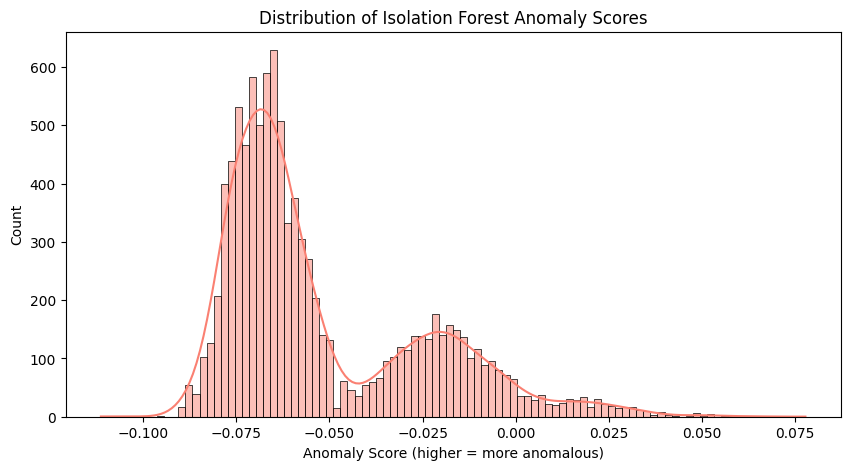

In [33]:
# Histogram
plt.figure(figsize=(10,5))
sns.histplot(anomaly_magnitude, bins=100, kde=True, color='salmon')
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Count")
plt.show()

##### Cumulative fraction

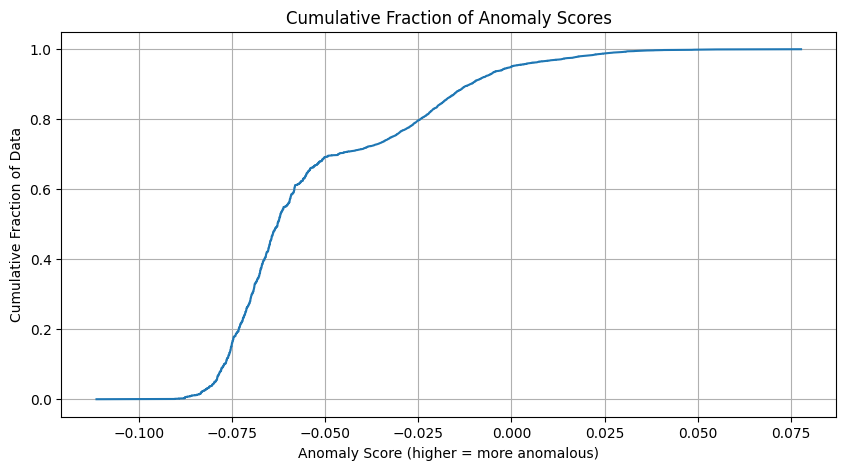

In [34]:
sorted_scores = np.sort(anomaly_magnitude)
cumulative_fraction = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)

plt.figure(figsize=(10,5))
plt.plot(sorted_scores, cumulative_fraction)
plt.title("Cumulative Fraction of Anomaly Scores")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Cumulative Fraction of Data")
plt.grid(True)
plt.show()

#### Threshold for top 5% anomalies

In [35]:
threshold = np.percentile(anomaly_magnitude, 95)
print("Score threshold for ~5% anomalies:", threshold)

# Quick check
print(df['is_anomaly'].value_counts())


Score threshold for ~5% anomalies: 0.0
is_anomaly
0    9502
1     498
Name: count, dtype: int64


In [36]:
df.head()

,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,date,hour,dayofweek,time_of_day,log_amount,anomaly_score,anomaly_flag,is_anomaly
0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-16 21:45:13,2024-06-16,21,6,Night,7.881314,0.068983,1,0
1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,0,0,0,2024-06-05 00:49:25,2024-06-05,0,2,Night,7.953561,0.014250,1,0
2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,0,0,1,2024-06-13 15:54:02,2024-06-13,15,3,Afternoon,7.777147,-0.018039,-1,1
3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,0,0,1,2024-06-10 01:05:49,2024-06-10,1,0,Night,7.521323,0.028900,1,0
4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-27 02:28:53,2024-06-27,2,3,Night,6.926184,0.109955,1,0


In [37]:
X_df.head()

,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,transaction_type_ Withdraw Cash,transaction_type_ Buy Airtime,transaction_type_ Send Money,transaction_type_ Buy Airtime,transaction_type_Buy Airtime,transaction_type_Deposit Cash,transaction_type_Lipa na M-Pesa,...,location_Nyeri,location_Thika,device_type_Android,device_type_Feature Phone,device_type_iOS,network_provider_Airtel,network_provider_Safaricom,network_provider_Telkom Kenya,user_type_agent,user_type_individual
0,-0.184443,-0.23373,-0.326063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.184443,-0.23373,-0.326063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.184443,-0.23373,3.066892,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.184443,-0.23373,3.066892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.184443,-0.23373,-0.326063,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


## Anomaly Visualization

### With t-SNE

Running t-SNE...


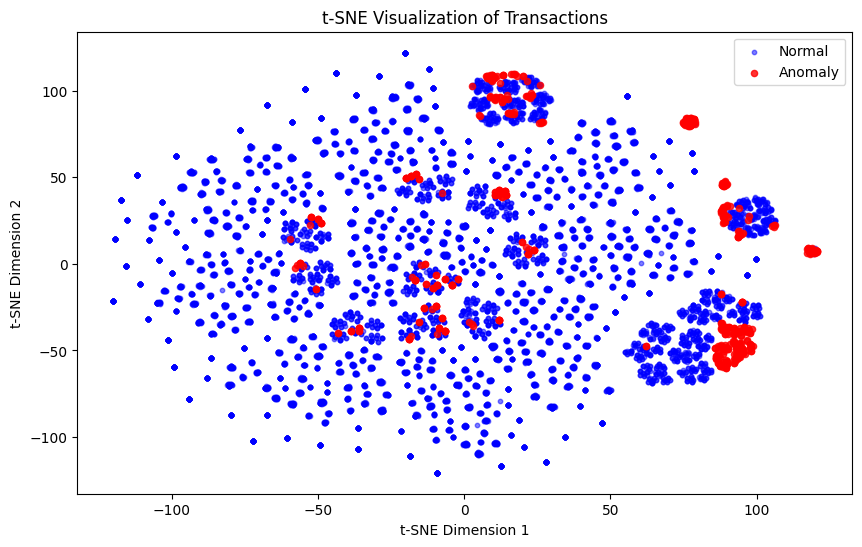

In [38]:
# Run t-SNE (this might take ~1-2 minutes on 10k rows)
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X_df)

# Add t-SNE results to dataframe
df['tsne_x'] = X_embedded[:, 0]
df['tsne_y'] = X_embedded[:, 1]

# Plot anomalies vs. normal
plt.figure(figsize=(10, 6))
plt.scatter(df.loc[df['is_anomaly'] == 0, 'tsne_x'],
            df.loc[df['is_anomaly'] == 0, 'tsne_y'],
            c='blue', label='Normal', alpha=0.5, s=10)

plt.scatter(df.loc[df['is_anomaly'] == 1, 'tsne_x'],
            df.loc[df['is_anomaly'] == 1, 'tsne_y'],
            c='red', label='Anomaly', alpha=0.8, s=20)

plt.title("t-SNE Visualization of Transactions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


### With UMAP

Running UMAP...


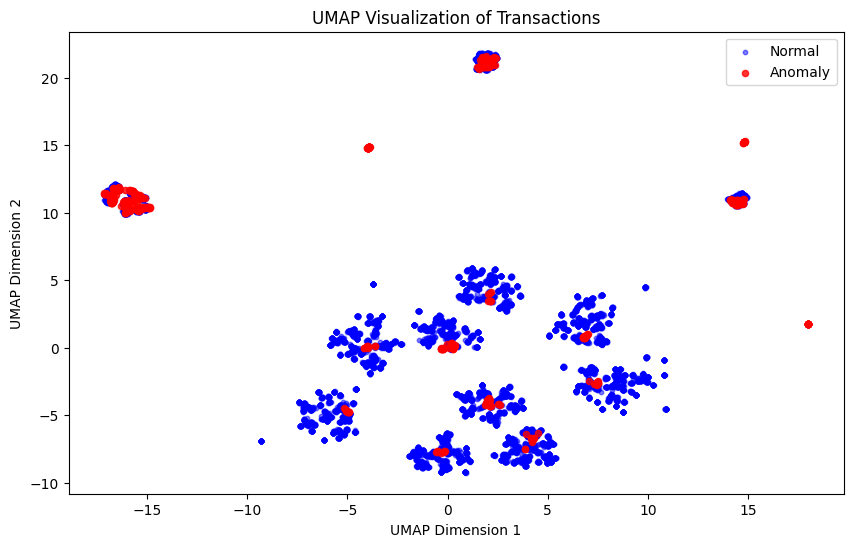

In [39]:
# Run UMAP
print("Running UMAP...")
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_df)

# Add UMAP results to dataframe
df['umap_x'] = X_umap[:, 0]
df['umap_y'] = X_umap[:, 1]

# Plot anomalies vs. normal
plt.figure(figsize=(10, 6))
plt.scatter(df.loc[df['is_anomaly'] == 0, 'umap_x'],
            df.loc[df['is_anomaly'] == 0, 'umap_y'],
            c='blue', label='Normal', alpha=0.5, s=10)

plt.scatter(df.loc[df['is_anomaly'] == 1, 'umap_x'],
            df.loc[df['is_anomaly'] == 1, 'umap_y'],
            c='red', label='Anomaly', alpha=0.8, s=20)

plt.title("UMAP Visualization of Transactions")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()


## Save the trained model

In [40]:
# Save the dataset
df.to_csv("../data/transactions_with_anomalies.csv", index=False)

In [41]:
# move the model to google drive
joblib.dump(model, "../models/isolation_forest.joblib")

['../models/isolation_forest.joblib']

##  Quick summary for reporting

In [42]:
total = len(df)
anomalies = df['is_anomaly'].sum()

print("\n===== SUMMARY =====")


print(f"Total transactions: {total}")
print(f"Flagged anomalies: {anomalies} ({anomalies/total:.2%})")

print("\nAnomalies by transaction type:")
print(df.groupby('transaction_type')['is_anomaly'].sum())

print("\nAnomalies by location:")
print(df.groupby('location')['is_anomaly'].sum())

print("\nAnomalies by device type:")
print(df.groupby('device_type')['is_anomaly'].sum())

print("\nAnomalies by device Network provider:")
print(df.groupby('network_provider')['is_anomaly'].sum())

print("\nAnomalies by device user type:")
print(df.groupby('user_type')['is_anomaly'].sum())


===== SUMMARY =====
Total transactions: 10000
Flagged anomalies: 498 (4.98%)

Anomalies by transaction type:
transaction_type
Buy Airtime        95
Deposit Cash       55
Lipa Na M-Pesa     60
Pay Bill          141
Send Money         87
Withdraw Cash      60
Name: is_anomaly, dtype: int64

Anomalies by location:
location
Eldoret     54
Garissa     31
Kisumu      41
Machakos    33
Meru        51
Mombasa     46
Nairobi     46
Nakuru      64
Nyeri       37
Thika       95
Name: is_anomaly, dtype: int64

Anomalies by device type:
device_type
Android          140
Feature Phone    155
iOS              203
Name: is_anomaly, dtype: int64

Anomalies by device Network provider:
network_provider
Airtel          161
Safaricom       166
Telkom Kenya    171
Name: is_anomaly, dtype: int64

Anomalies by device user type:
user_type
agent         415
individual     83
Name: is_anomaly, dtype: int64
